In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
%matplotlib inline

In [2]:
#@title Definições de funções auxiliares
from numpy.linalg import norm

def init_W(K, M):
    W = np.zeros((K, M, M))
    W[:, np.arange(M), np.arange(M)] = 1
    W += np.random.rand(*W.shape) / 10
    return W
    

def angle(a, b):
    return a.dot(b) / (norm(a) * norm(b))

def get_random_not_orthogonal(x):
    x = x.flatten()
    tries = 0
    while True:
        r = np.random.rand(len(x)).flatten()
        a = angle(r, x)
        if np.abs(a) <= 1e-4:
            tries += 1
            continue
        if tries >= 10:
            raise Exception("FAIL", x, r, a)
#         if a <= 1e-4:
#             raise Exception("FAIL", x, r, a)
        return r
    
def recursive_h(W, sanity_check=False):
    # Adali 2010
    W = W.copy()
    M, M = W.shape
    Q = list()
    Q_inv = list()
    h = list()
    c = list()
    
    # c_n calculations
    for n in range(M - 1):
        W_n = W[np.arange(M) != n] # Size M - 1

        c_n = np.array(
            [
                (W[n] - W[n + 1]).T @ W[i] if i != n else (norm(W[n]) ** 2 - norm(W[n + 1]) ** 2) / 2
                for i
                in range(M)
                if i != n + 1
            ]
        ).reshape(-1, 1)
        c.append(c_n)

    # First Q
    W_1 = W[np.arange(M) != 0]
    Q_1 = W_1 @ W_1.T
    Q_inv.append(np.linalg.inv(Q_1))
    # Q_{n+1} calculation
    for n in range(M - 1):
        # Calculate Q_{n+1} from Q_{n}, starting from precalculated Q_1
        e_n = np.zeros((M - 1, 1))
        c_n = c[n]
        # e has the (n-1)th value equal to 1 because we are calculating Q_n instead of Q_{n+1}
        e_n[n] = 1
        Q_n_inv = Q_inv[n]
        Qn_1_inv = Q_n_inv - Q_n_inv @ c_n @ e_n.T @ Q_n_inv / ( 1 + e_n.T @ Q_n_inv @ c_n)
        Qn_1_inv = Qn_1_inv - Qn_1_inv @ e_n @ c_n.T @ Qn_1_inv / ( 1 + c_n.T @ Qn_1_inv @ e_n)
        # Append Q_n+1 to Q, until M - 1 (n + 1= M)
        Q_inv.append(Qn_1_inv)

    
    for n in range(M):
        W_n = W[np.arange(M) != n]
        r = get_random_not_orthogonal(W[n]).reshape(-1, 1)
        P_n = np.eye(M) - W_n.T @ Q_inv[n] @ W_n
        
        h_n = P_n @ r
        h_n /= norm(h_n, 2)
        if sanity_check:
            sanity = W[np.arange(M) != n] @ h_n
            assert np.allclose(sanity, 0, atol=1e-5), f"For h_{n}: " + str(sanity)
        h.append(h_n)
    return np.stack(h)

def get_hn(W, n, sanity_check=False):
    M, _ = W.shape
    W_n = W[np.arange(M) != n]
    Q_inv = np.linalg.inv(W_n @ W_n.T)
    r = get_random_not_orthogonal(W[n]).reshape(-1, 1)
    P_n = np.eye(M) - W_n.T @ Q_inv @ W_n

    h_n = P_n @ r
    h_n /= norm(h_n, 2)
    if sanity_check:
        assert np.allclose(W_n @ h_n, 0, atol=1e-5)
    return h_n

def non_recursive_h(W, sanity_check=False):
    # Adali 2010
    W = W.copy()
    M, M = W.shape
    h = list()
    
    for n in range(M):
        h_n = get_hn(W, n)
        if sanity_check:
            sanity = W[np.arange(M) != n] @ h_n
            assert np.allclose(sanity, 0, atol=1e-5), f"For h_{n}: " + str(sanity)
        h.append(h_n)
            
    return np.stack(h)

def ISI(W, A):
    # https://github.com/trendscenter/gift/blob/ca71b3ab852423f1c2dc118017917a231265fc84/GroupICATv4.0c/icatb/icatb_analysis_functions/icatb_algorithms/icatb_iva_laplace.m
    assert W.shape == A.shape
    K, M, _ = W.shape
    G = np.stack([W[k] @ A[k] for k in range(K)])
    G = np.abs(G).sum(axis=0)
    isi = 1 / (2 * M * (M - 1))
    score = - 2 * M
    score += (G / G.max(axis=1, keepdims=True)).sum()
    score += (G / G.max(axis=0, keepdims=True)).sum()

    return isi * score

def ISR(W, A):
    assert W.shape == A.shape
    K, M, _ = W.shape
    G = np.stack([w @ a for w, a in zip(W, A)])
    G = np.stack([g - np.diag(g.diagonal()) for g in G])
    
    score = np.power(G, 2).sum() / (K * M * (M - 1))
    return score

def whitening_multivar_matrix(X):
#     cov = np.cov(X, rowvar=True, bias=False)
    cov = X @ X.T / len(X.T)
    d, E = np.linalg.eigh(cov)
    
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    B = E @ D_inv @ E.T
    return B

def whitening_multivar(X):
    X = X.copy()
#     cov = np.cov(X, rowvar=True, bias=False)
    B = whitening_multivar_matrix(X)
    X -= X.mean(axis=1, keepdims=True)
    return B @ X

def sample_iva_data(K, M, N, seed=42):
    # K number of datasets
    # M number of SVC (electrodes)
    # N number of samples
    # Sample data as in Anderson 2012 (Joint Blind Source Separation With Multivariate Gaussian Model: Algorithms and Performance Analysis)
    np.random.seed(seed)

    S = np.zeros((M, N, K))
    for m in range (M):
        cov = np.random.normal(size=(K, K))
        cov = cov @ cov.T
        SCV = np.random.multivariate_normal(np.zeros(K), cov, size=N) # K, N
        S[m] = SCV
    S = S.transpose(2, 0, 1)
    assert S.shape == (K, M, N)        
        
    A = np.random.normal(0, 1, size=(K, M, M))
    X = np.stack([a @ s for a, s in zip(A, S)])
    assert np.all((A[0] @ S[0]) == X[0])
    return X, S, A


In [4]:
#@title Qual dataset usar? { run: "auto", vertical-output: true }

dropdown = 'anderson' #@param ["caroline", "anderson"]

if dropdown == "anderson":
  K = 4
  M = 40
  N = 10_000

  def sample_iva_data(K, M, N, seed=42):
      # K number of datasets
      # M number of SVC (electrodes)
      # N number of samples
      # Sample data as in Anderson 2012 (Joint Blind Source Separation With Multivariate Gaussian Model: Algorithms and Performance Analysis)
      np.random.seed(seed)

      X, S, A = list(), list(), list()
      SCVs = list()
      for m in range (M):
          cov = np.random.normal(size=(K, K))
          cov = cov @ cov.T
          SCV = np.random.multivariate_normal(np.zeros(K), cov, size=N).T # K, N
          SCVs.append(SCV)
      S = np.stack(SCVs).transpose(1, 0, 2)
      assert S.shape == (K, M, N)        
          
      A = np.random.normal(0, 1, size=(K, M, M))
      X = np.stack([a @ s for a, s in zip(A, S)])
      assert np.all((A[0] @ S[0]) == X[0])
      return X, S, A


  X, S, A = sample_iva_data(K, M, N)
elif dropdown == "caroline":

  N = 25000
  M = 2
  K = 3

  s_1_1 = np.random.rand(N) * 2 - 1
  s_2_1 = np.random.rand(N) * 2 - 1

  g_1_2 = [-.3, -0.07, .2, -.021, 0.01]
  g_2_2 = [-.1, 0.02, .25]
  g_1_3 = [-.1, 0.02, .25]
  g_2_3 = [.022, 0.4, -.09]

  s_1_2 = np.convolve(s_1_1, g_1_2, mode="same")
  s_2_2 = np.convolve(s_2_1, g_2_2, mode="same")
  s_1_3 = np.convolve(s_1_1, g_1_3, mode="same")
  s_2_3 = np.convolve(s_2_1, g_2_3, mode="same")

  SCV_1 = np.stack([s_1_1, s_1_2, s_1_3])
  SCV_2 = np.stack([s_2_1, s_2_2, s_2_3])
  S = np.stack([SCV_1, SCV_2]).transpose(1, 0, 2)

  A = np.stack(
      [
          [
              [.65, .23],
              [.35, .76]
          ],
          [
              [.8, -.53],
              [.14, -.63]
          ],
          [
              [.83, -.79],
              [.15, -.24]
          ]
      ]
  )
  X = A @ S
else:
  raise("Select 'caroline' or 'anderson'!")
W_opt = np.stack([np.linalg.inv(a) for a in A])
print(f"Created {K} datasets, each one with {M} sources. For each source there are {N} data points")

Created 4 datasets, each one with 40 sources. For each source there are 10000 data points


In [5]:
#@title Definição da função IVA - Multivariate Gaussian Sources (Vector Gradient Descent) 
from scipy.linalg import sqrtm
def IVA_GV(Z, whiten=True, lr=1e-2, epochs=100, A=None, sanity_check=False, lr_scale=.9):
    """Run IVA wiith multivariate Gaussian model with Vector Gradient descent.
    
    Z is the input array and is shaped K, M, N where
        K is the number of datasets
        M is the number of sources and observations
        N in the number of time samples
        
    W is the array with the weights and is shaped K, M, M (one M,M matrix per dataset)
    
    Based on Joint Blind Source Separation With Multivariate Gaussian Model: Algorithms and Performance Analysis
    
    """
    
    # Z = np.stack([whitening_multivar(z) for z in Z])
    # Z = B @ X
    # X = A @ S
    # Z = B @ A @ S
    # A' = B @ A
    K, M, N = Z.shape
  
    B = np.stack([np.eye(M, M) for _ in range(K)])
    if whiten:
      B = np.stack([whitening_multivar_matrix(x) for x in Z])
    Z = np.stack([b @ x for b, x in zip(B, X)])

    # If whitening is considered, it is like assuming that the real Mixing matrix is premultiplied by B
    # Because:
    # X = A @ S
    # Z = A' @ S, with Z = B @ X and A' = B @ A
    if A is None:
      A = np.random.rand(K, M, M)
    A = B @ A

    grad_norm_history = np.empty((K, M, epochs))
    total_norm_history = np.empty(epochs)
    cost = np.zeros(epochs)
    cost_const = K * np.log(2 * np.pi * np.e)
    ISI_history = np.empty(epochs)
    ISR_history = np.empty(epochs)
    W = np.stack([np.eye(M) for _ in range(K)])

    m = 0
    # Epochs = iterations of gradient descent
    R = np.empty((K, K, M, M))
    for k1 in range(K):
        for k2 in range(K):
            R[k1, k2] = Z[k1] @ Z[k2].T / N

    pbar = tqdm(range(epochs))
    for i in pbar:
        # Y is the estimated sources at this iteration
        Y = np.stack([w @ z for w, z in zip(W, Z)]) # K, M, N
        Y = W @ Z # K, M, N
        W_old = W.copy()
        
        # H contains the h_n^k vectors (h_n^k is indexed at H[k, n], with shape (M,1))
        # H is shaped K, M, M, 1

        # Weight matrices update loops
        ## Iterate every dataset 
#         H = np.stack([non_recursive_h(W[k], sanity_check=sanity_check) for k in range(K)]) # K x M x M x 1
        cost[i] = 0
        for n in range(M):
            sigma_n = np.empty((K, K))
            for k1 in range(K):
                for k2 in range(k1, K):
                    sigma_n[k1, k2]  = W[[k1], n] @ R[k1, k2] @ W[[k2], n].T
                    if k1 != k2:
                        sigma_n[k2, k1] = sigma_n[k1, k2]
            
            sigma_inv = np.linalg.inv(sigma_n)
            cost[i] += .5 * (cost_const + np.log(np.linalg.det(sigma_n)))

            for k in range(K):
                e = np.zeros((K, 1))
                e[k] = 1
                ## Iterate every row of the W_k
                
                # Calculation of equation 18 in Anderson 2012
                # X @ Y[:, n].T = X @ (W @ X)[:, n].T = X @ X.T @ W.T = R @ W.T
                # grad = E_xk_yn @ sigma_inv @ e
                # E_xk_yn = (Z[k] @ Y[:, n].T) / N
                h_k_n = get_hn(W[k], n, sanity_check=sanity_check)
                E_xk_yn = np.array([R[k, k_i] @ W[[k_i], n].flatten() for k_i in range(K)]).T

                grad = -h_k_n / (h_k_n.T @ W[k, n]) #, H = K, M, M, 1

                grad += E_xk_yn @ sigma_inv @ e
                # for kk in range(K):
                #   grad += R[k, kk] @ W[kk, n].reshape(M, 1) @ sigma_inv[kk, k].reshape(1, 1)

                grad = grad.flatten()

                # Apply the gradient
                diff = lr * (grad / norm(grad, 2))
                w_n_new = W[k, n] - diff
                # Normalize the row
                w_n_new = w_n_new / norm(w_n_new, 2)
                
                grad_norm_history[k, n, i] = norm(grad, 2)
                
                # Substitute the new row
                W[k, n] = w_n_new
            
                # Update sigma at row and colum k
                for kk in range(K):
                    sigma_n[k, kk] = W[[k], n] @ R[k, kk] @ W[[kk], n].T
                    sigma_n[kk, k] = sigma_n[k, kk]
                sigma_inv = np.linalg.inv(sigma_n)

#                 H[k, n] = get_hn(W[k], n)
        if A is not None:
            ISI_history[i] = ISI(W, A)
            ISR_history[i] = ISR(W, A)

        total_norm_history[i] = norm(W_old - W)
        if i > 0: 
          if cost[i] > cost[i - 1]:
            lr *= lr_scale
            lr = max(lr, 1e-4)

        desc = "Cost: {:.2f} - LR: {:.2f} - Joint ISI: {:.2f}".format(cost[i], np.log10(lr), np.log10(ISI_history[i]))
        pbar.set_description(desc)

    return W, B, grad_norm_history, total_norm_history, ISI_history, ISR_history

# IVA_GV(X, A=A, epochs=10);


In [6]:
#@title Definição da função IVA - Multivariate Gaussian Sources (Vector Gradient Descent + ADAM) 
def IVA_GV_ADAM(Z, whiten=True, lr=1e-2, epochs=100, A=None, sanity_check=False, b1=.9, b2=.999, lr_scale=.9):
    """Run IVA wiith multivariate Gaussian model with Vector Gradient descent.
    
    Z is the input array and is shaped K, M, N where
        K is the number of datasets
        M is the number of sources and observations
        N in the number of time samples
        
    W is the array with the weights and is shaped K, M, M (one M,M matrix per dataset)
    
    Based on Joint Blind Source Separation With Multivariate Gaussian Model: Algorithms and Performance Analysis
    
    """
    
    # Z = np.stack([whitening_multivar(z) for z in Z])
    # Z = B @ X
    # X = A @ S
    # Z = B @ A @ S
    # A' = B @ A
    K, M, N = Z.shape
  
    B = np.stack([np.eye(M, M) for _ in range(K)])
    if whiten:
      B = np.stack([whitening_multivar_matrix(x) for x in Z])
    Z = np.stack([b @ x for b, x in zip(B, X)])

    # If whitening is considered, it is like assuming that the real Mixing matrix is premultiplied by B
    # Because:
    # X = A @ S
    # Z = A' @ S, with Z = B @ X and A' = B @ A
    if A is None:
      A = np.random.rand(K, M, M)
    A = B @ A

    grad_norm_history = np.empty((K, M, epochs))
    total_norm_history = np.empty(epochs)
    cost = np.zeros(epochs)
    cost_const = K * np.log(2 * np.pi * np.e)
    ISI_history = np.empty(epochs)
    ISR_history = np.empty(epochs)
    W = np.stack([np.eye(M) for _ in range(K)])

    # Epochs = iterations of gradient descent
    R = np.empty((K, K, M, M))
    for k1 in range(K):
        for k2 in range(K):
            R[k1, k2] = Z[k1] @ Z[k2].T / N

    m = np.zeros((2, K, M, M))
    v = np.zeros((2, K, M, M))

    pbar = tqdm(range(epochs))
    for i in pbar:
        # Y is the estimated sources at this iteration
        Y = np.stack([w @ z for w, z in zip(W, Z)]) # K, M, N
        Y = W @ Z # K, M, N
        W_old = W.copy()
        
        # H contains the h_n^k vectors (h_n^k is indexed at H[k, n], with shape (M,1))
        # H is shaped K, M, M, 1

        # Weight matrices update loops
        ## Iterate every dataset 
#         H = np.stack([non_recursive_h(W[k], sanity_check=sanity_check) for k in range(K)]) # K x M x M x 1
        cost[i] = 0
        for n in range(M):
            sigma_n = np.empty((K, K))
            for k1 in range(K):
                for k2 in range(k1, K):
                    sigma_n[k1, k2]  = W[[k1], n] @ R[k1, k2] @ W[[k2], n].T
                    if k1 != k2:
                        sigma_n[k2, k1] = sigma_n[k1, k2]
            
            sigma_inv = np.linalg.inv(sigma_n)
            cost[i] += .5 * (cost_const + np.log(np.linalg.det(sigma_n)))

            for k in range(K):
                e = np.zeros((K, 1))
                e[k] = 1
                ## Iterate every row of the W_k
                
                # Calculation of equation 18 in Anderson 2012
                # X @ Y[:, n].T = X @ (W @ X)[:, n].T = X @ X.T @ W.T = R @ W.T
                # grad = E_xk_yn @ sigma_inv @ e
                # E_xk_yn = (Z[k] @ Y[:, n].T) / N
                h_k_n = get_hn(W[k], n, sanity_check=sanity_check)
                E_xk_yn = np.array([R[k, k_i] @ W[[k_i], n].flatten() for k_i in range(K)]).T

                grad = -h_k_n / (h_k_n.T @ W[k, n]) #, H = K, M, M, 1

                grad += E_xk_yn @ sigma_inv @ e
                # for kk in range(K):
                #   grad += R[k, kk] @ W[kk, n].reshape(M, 1) @ sigma_inv[kk, k].reshape(1, 1)

                grad = grad.flatten()

                m[1, k, n] = b1 * (m[0, k, n]) + (1 - b1) * grad
                v[1, k, n] = b2 * (v[0, k, n]) + (1 - b2) * grad ** 2
            
                mhat = m[1, k, n] / (1 - b1**(i + 1))
                vhat = v[1, k, n] / (1 - b2**(i + 1))
    
                # Apply the gradient
#                 w_n_new = W[k, n] - lr * (grad / norm(grad, 2))
                diff = lr * mhat / (np.sqrt(vhat) + 1e-6)
                w_n_new  = W[k, n] - diff

                # Apply the gradient
                w_n_new = w_n_new / norm(w_n_new, 2)
                
                grad_norm_history[k, n, i] = norm(grad, 2)
                
                # Substitute the new row
                W[k, n] = w_n_new
            
                m[0, k, n] = m[1, k, n]
                v[0, k, n] = v[1, k, n]

                # Update sigma at row and colum k
                for kk in range(K):
                    sigma_n[k, kk] = W[[k], n] @ R[k, kk] @ W[[kk], n].T
                    sigma_n[kk, k] = sigma_n[k, kk]
                sigma_inv = np.linalg.inv(sigma_n)

#                 H[k, n] = get_hn(W[k], n)
        if A is not None:
            ISI_history[i] = ISI(W, A)
            ISR_history[i] = ISR(W, A)

        total_norm_history[i] = norm(W_old - W)
        if i > 0: 
          if cost[i] > cost[i - 1]:
            lr *= lr_scale
            lr = max(lr, 1e-3)

        desc = "Cost: {:.2f} - LR: {:.2f} - Joint ISI: {:.2f}".format(cost[i], np.log10(lr), np.log10(ISI_history[i]))
        pbar.set_description(desc)

    return W, B, grad_norm_history, total_norm_history, ISI_history, ISR_history

# IVA_GV_ADAM(X, A=A, epochs=10);


# Comparison

In [7]:
print("IVA with pre-whitening")
IVA_GV(X, whiten=True, A=A, epochs=100, lr=1, sanity_check=True)
print()

print("IVA+ADAM with pre-whitening")
IVA_GV_ADAM(X, whiten=True, A=A, epochs=100, lr=1, sanity_check=True);
print()

print("IVA without pre-whitening")
IVA_GV(X, whiten=False, A=A, epochs=1000, lr=1, sanity_check=True);
print()

print("IVA+ADAM without pre-whitening")
IVA_GV_ADAM(X, whiten=False, A=A, epochs=1000, lr=1, sanity_check=True);
print()


IVA with pre-whitening


Cost: 153.85 - LR: -1.51 - Joint ISI: -2.18: 100%|██████████| 100/100 [00:19<00:00,  5.01it/s]



IVA+ADAM with pre-whitening


Cost: 176.01 - LR: -1.14 - Joint ISI: -1.26: 100%|██████████| 100/100 [00:11<00:00,  8.57it/s]



IVA without pre-whitening


Cost: 340.85 - LR: -2.47 - Joint ISI: -1.04: 100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]



IVA+ADAM without pre-whitening


Cost: 314.22 - LR: -3.00 - Joint ISI: -1.21: 100%|██████████| 1000/1000 [01:45<00:00,  9.51it/s]

Cost: 153.85 - LR: -1.51 - Joint ISI: -2.18: 100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


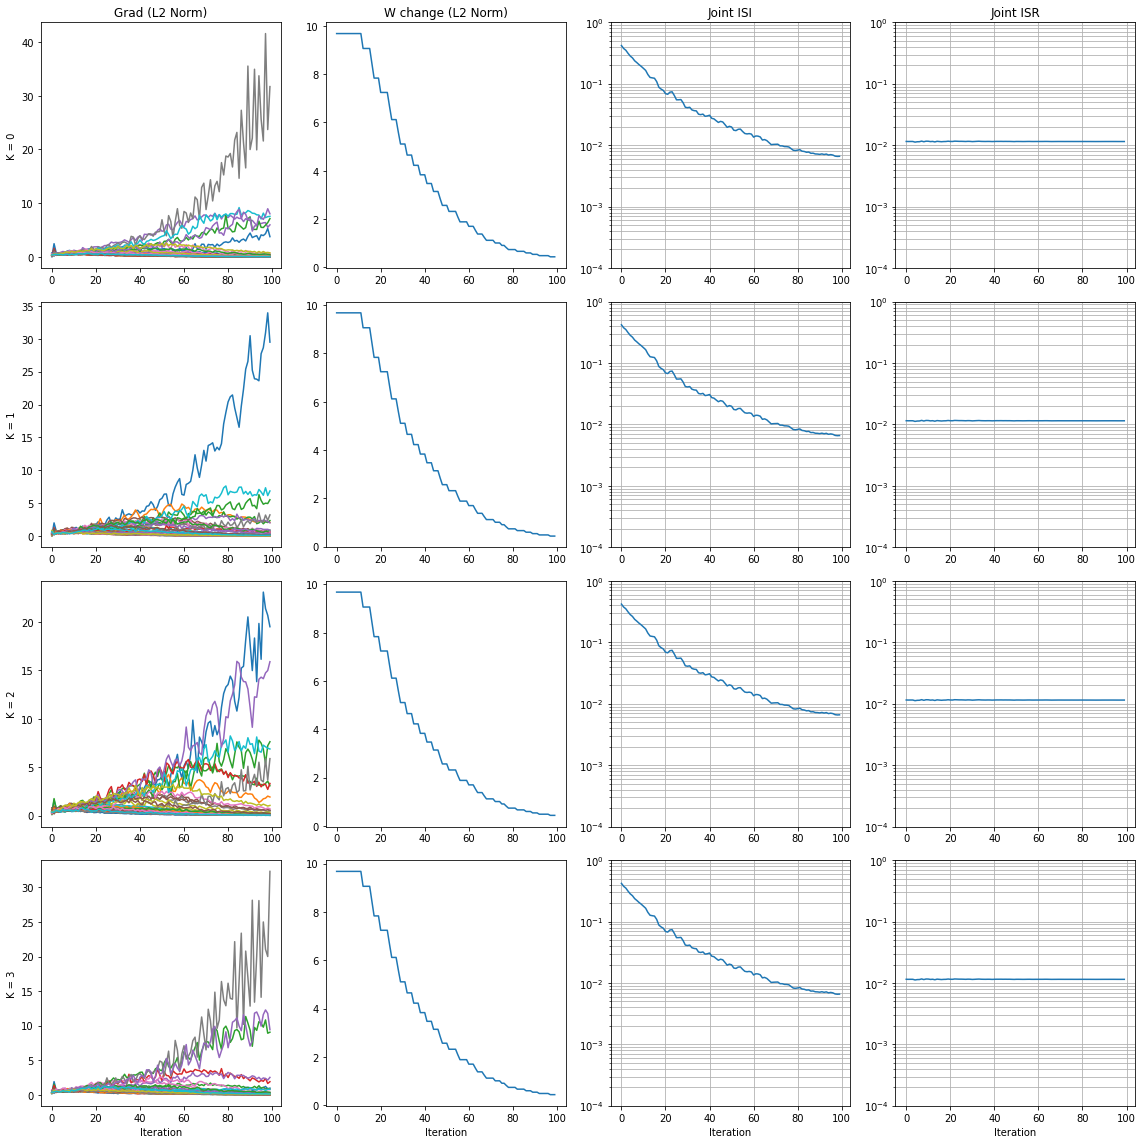

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


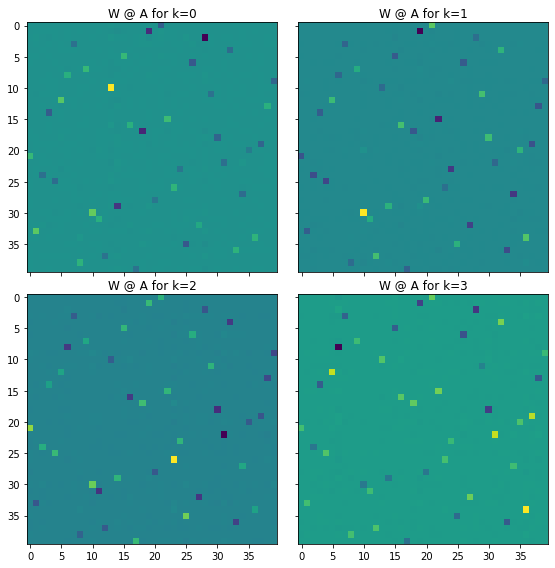

In [9]:
#@title Set custom parameters for IVA
pre_whitening = True #@param {type:"boolean"}
number_iterations = 100 #@param {type:"integer"}
step_size = 1.0 #@param {type:"number"}

from mpl_toolkits.axes_grid1 import ImageGrid

W, B, grad_history, norm_history, ISI_history, ISR_history = IVA_GV(X, whiten=pre_whitening, A=A, epochs=number_iterations, lr=step_size, sanity_check=True)
fig, axes = plt.subplots(K, 4, figsize=(16, 4 * K))

for k in range(K):
    values = (grad_history[k].T, norm_history, ISI_history, ISR_history)
    axes[k, 0].set_ylabel(f"K = {k}")

    for col in range(len(values)):
        axes[k, col].plot(values[col])
        if k == (K - 1):
          axes[k, col].set_xlabel("Iteration")
        if col not in (0, 1):
            axes[k, col].set_ylim((1e-4, 1))
            axes[k, col].set_yscale("log")
            axes[k, col].grid(which="both")

axes[0, 0].set_title("Grad (L2 Norm)")
axes[0, 1].set_title("W change (L2 Norm)")
axes[0, 2].set_title("Joint ISI")
axes[0, 3].set_title("Joint ISR")

plt.tight_layout()
plt.show()

nrows, ncols = (int(np.sqrt(K)), int(np.ceil(K / np.sqrt(K))))
fig = plt.figure(figsize=(4. * ncols, 4. * nrows))
grid = ImageGrid(
    fig, 111,  # similar to subplot(111)
    nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
    axes_pad=0.3,  # pad between axes in inch.
)


for ax, k in zip(grid, range(K)):
    # Iterating over the grid returns the Axes.
    ax.imshow(W[k] @ (B @ A)[k])
    ax.set_title(f"W @ A for k={k}")

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(K, 4, figsize=(16, 4 * K))

for k in range(K):
    values = (norm_history, grad_history[k].T, ISI_history, ISR_history)
    for col in range(len(values)):
        axes[k, col].plot(values[col])
        if not (col in [0, 1]):
            axes[k, col].set_ylim((1e-4, 1))
            axes[k, col].set_yscale("log")
            axes[k, col].grid(which="both")

axes[0, 0].set_title("Weight norm change")
axes[0, 1].set_title("ISI")
axes[0, 2].set_title("ISR")

plt.tight_layout()

# W, delta_history, ISI_history, ISR_history = IVA_GV(X, A=A, epochs=1000, lr=.01, sanity_check=False)
# W, delta_history, ISI_history, ISR_history = IVA_GV(X, A=A, epochs=2000, lr=.1, sanity_check=False)


In [ ]:
np.log10(ISI_history)